# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling1D, concatenate, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('data/DB1_S1_image.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  
file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
# data  = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label,52).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

/home/malele/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train shape: (12038, 12, 10)
Y_train shape: (12038, 52)
X_test shape: (3009, 12, 10)
Y_test shape: (3009, 52)


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


# 建立模型

In [3]:
def CNN(input_shape=(12,10), classes=52): 
    X_input = Input(input_shape)
    
    length=12
    convs=[]
    filter_sizes=[2, 3, 4, 5]
    
    for filters in filter_sizes:
        layer_conv = Conv1D(filters=128, kernel_size=filters, activation='relu')(X_input)
        layer_pool = MaxPooling1D(length-filters+1)(layer_conv)
        layer_pool = Flatten()(layer_pool)
        convs.append(layer_pool)
    merge = concatenate(convs,axis=1)
    
    X = merge
    #X = Dropout(0.5)(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model
    
model = CNN(input_shape = (12, 10), classes = 52)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 10)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 11, 128)      2688        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 128)      3968        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 9, 128)       5248        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (

# 训练原始数据

In [4]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=200, batch_size=64, verbose=1, 
            validation_data=(X_test, Y_test),callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

end = time.time()
print("time:",end-start)

Train on 12038 samples, validate on 3009 samples
Epoch 1/200
12038/12038 [==============================] - 2s 170us/step - loss: 3.3330 - acc: 0.1497 - val_loss: 2.7030 - val_acc: 0.3519
Epoch 2/200
12038/12038 [==============================] - 1s 98us/step - loss: 2.6599 - acc: 0.2952 - val_loss: 2.2652 - val_acc: 0.4327
Epoch 3/200
12038/12038 [==============================] - 1s 96us/step - loss: 2.3560 - acc: 0.3686 - val_loss: 2.0343 - val_acc: 0.4892
Epoch 4/200
12038/12038 [==============================] - 1s 107us/step - loss: 2.1570 - acc: 0.4121 - val_loss: 1.8395 - val_acc: 0.5321
Epoch 5/200
12038/12038 [==============================] - 1s 103us/step - loss: 1.9969 - acc: 0.4458 - val_loss: 1.7153 - val_acc: 0.5494
Epoch 6/200
12038/12038 [==============================] - 1s 100us/step - loss: 1.8735 - acc: 0.4774 - val_loss: 1.5893 - val_acc: 0.5723
Epoch 7/200
12038/12038 [==============================] - 1s 102us/step - loss: 1.7934 - acc: 0.4979 - val_loss: 1.524

12038/12038 [==============================] - 1s 102us/step - loss: 0.9099 - acc: 0.7065 - val_loss: 0.8498 - val_acc: 0.7424
Epoch 60/200
12038/12038 [==============================] - 1s 101us/step - loss: 0.9085 - acc: 0.7098 - val_loss: 0.8401 - val_acc: 0.7404
Epoch 61/200
12038/12038 [==============================] - 1s 100us/step - loss: 0.9141 - acc: 0.7095 - val_loss: 0.8408 - val_acc: 0.7408
Epoch 62/200
12038/12038 [==============================] - 1s 105us/step - loss: 0.8999 - acc: 0.7095 - val_loss: 0.8380 - val_acc: 0.7418
Epoch 63/200
12038/12038 [==============================] - 1s 101us/step - loss: 0.9105 - acc: 0.7086 - val_loss: 0.8440 - val_acc: 0.7391
Epoch 64/200
12038/12038 [==============================] - 1s 106us/step - loss: 0.8920 - acc: 0.7096 - val_loss: 0.8281 - val_acc: 0.7414
Epoch 65/200
12038/12038 [==============================] - 1s 106us/step - loss: 0.8826 - acc: 0.7173 - val_loss: 0.8430 - val_acc: 0.7414
Epoch 66/200
12038/12038 [=======

12038/12038 [==============================] - 1s 102us/step - loss: 0.7004 - acc: 0.7658 - val_loss: 0.7814 - val_acc: 0.7680
Epoch 118/200
12038/12038 [==============================] - 1s 104us/step - loss: 0.7131 - acc: 0.7623 - val_loss: 0.8088 - val_acc: 0.7660
Epoch 119/200
12038/12038 [==============================] - 1s 99us/step - loss: 0.7038 - acc: 0.7696 - val_loss: 0.7941 - val_acc: 0.7587
Epoch 120/200
12038/12038 [==============================] - 1s 104us/step - loss: 0.6896 - acc: 0.7661 - val_loss: 0.7901 - val_acc: 0.7664
Epoch 121/200
12038/12038 [==============================] - 1s 101us/step - loss: 0.6868 - acc: 0.7711 - val_loss: 0.7906 - val_acc: 0.7670
Epoch 122/200
12038/12038 [==============================] - 1s 104us/step - loss: 0.6827 - acc: 0.7723 - val_loss: 0.7897 - val_acc: 0.7680
Epoch 123/200
12038/12038 [==============================] - 1s 106us/step - loss: 0.6833 - acc: 0.7730 - val_loss: 0.7803 - val_acc: 0.7714
Epoch 124/200
12038/12038 [=

12038/12038 [==============================] - 1s 108us/step - loss: 0.5701 - acc: 0.8058 - val_loss: 0.8217 - val_acc: 0.7730
Epoch 176/200
12038/12038 [==============================] - 1s 104us/step - loss: 0.5688 - acc: 0.8079 - val_loss: 0.8141 - val_acc: 0.7694
Epoch 177/200
12038/12038 [==============================] - 1s 98us/step - loss: 0.5794 - acc: 0.8000 - val_loss: 0.8062 - val_acc: 0.7727
Epoch 178/200
12038/12038 [==============================] - 1s 99us/step - loss: 0.5756 - acc: 0.8020 - val_loss: 0.8053 - val_acc: 0.7667
Epoch 179/200
12038/12038 [==============================] - 1s 107us/step - loss: 0.5667 - acc: 0.8054 - val_loss: 0.8153 - val_acc: 0.7707
Epoch 180/200
12038/12038 [==============================] - 1s 103us/step - loss: 0.5669 - acc: 0.8033 - val_loss: 0.8028 - val_acc: 0.7714
Epoch 181/200
12038/12038 [==============================] - 1s 102us/step - loss: 0.5745 - acc: 0.8050 - val_loss: 0.8123 - val_acc: 0.7660
Epoch 182/200
12038/12038 [==

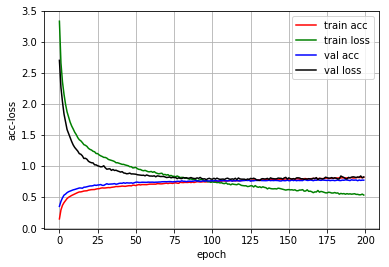

In [5]:
history.loss_plot('epoch')